In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=40
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

38

(40, 256, 256, 3)
[1 0 0 1 2 2 2 2 1 0 2 0 1 0 2 0 2 1 2 0 1 1 1 1 1 1 0 2 1 1 0 1 1 1 2 1 2
 0 0 1]


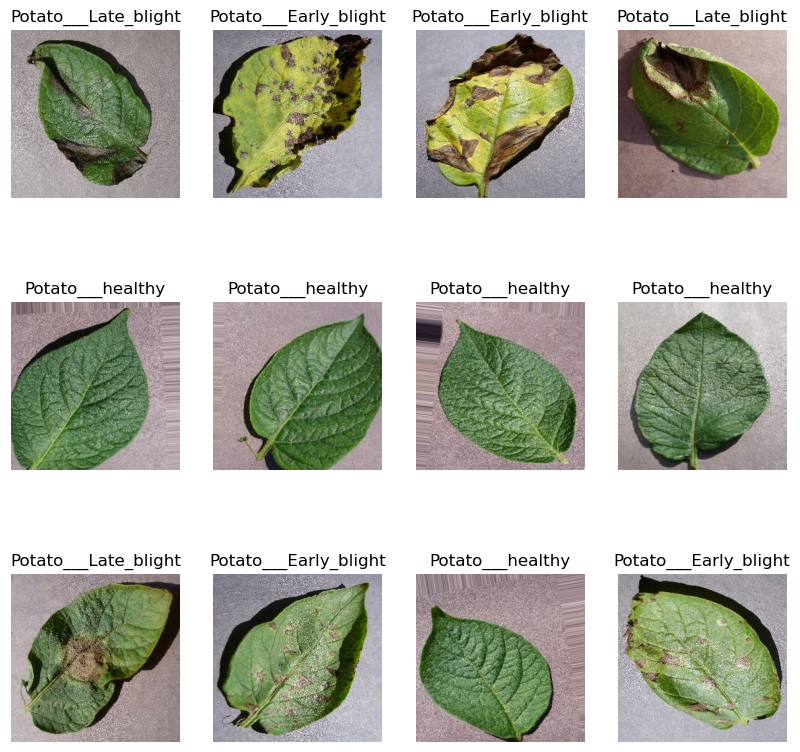

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

30 3 5


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (40, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (40, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (40, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (40, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (40, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (40, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
30/30 [==============================] - 45s 1s/step - loss: 1.0518 - accuracy: 0.4288 - val_loss: 0.9312 - val_accuracy: 0.4083
Epoch 2/20
30/30 [==============================] - 46s 2s/step - loss: 0.7962 - accuracy: 0.6178 - val_loss: 0.6381 - val_accuracy: 0.7167
Epoch 3/20
30/30 [==============================] - 46s 2s/step - loss: 0.5356 - accuracy: 0.7568 - val_loss: 0.4206 - val_accuracy: 0.8500
Epoch 4/20
30/30 [==============================] - 45s 2s/step - loss: 0.4106 - accuracy: 0.8280 - val_loss: 0.5461 - val_accuracy: 0.7333
Epoch 5/20
30/30 [==============================] - 45s 2s/step - loss: 0.4117 - accuracy: 0.8280 - val_loss: 0.3462 - val_accuracy: 0.8583
Epoch 6/20
30/30 [==============================] - 46s 2s/step - loss: 0.2522 - accuracy: 0.8983 - val_loss: 0.3107 - val_accuracy: 0.9000
Epoch 7/20
30/30 [==============================] - 45s 2s/step - loss: 0.1943 - accuracy: 0.9314 - val_loss: 0.2571 - val_accuracy: 0.9417
Epoch 8/20
30/30 [==

In [13]:
scores=model.evaluate(test_ds)
scores

5/5 [==============================] - 2s 287ms/step - loss: 0.0596 - accuracy: 0.9750


[0.059619221836328506, 0.9750000238418579]

In [14]:
history.history['loss']

[1.0518170595169067,
 0.7962087988853455,
 0.5356153249740601,
 0.41055619716644287,
 0.4116547703742981,
 0.2521705627441406,
 0.1942952275276184,
 0.1742679923772812,
 0.16525088250637054,
 0.13653892278671265,
 0.1756220906972885,
 0.15489763021469116,
 0.11002849042415619,
 0.11430712044239044,
 0.09037350863218307,
 0.11271948367357254,
 0.09755348414182663,
 0.0662972554564476,
 0.08721219003200531,
 0.13381768763065338]

In [15]:
history.history['accuracy']

[0.42881354689598083,
 0.6177965998649597,
 0.756779670715332,
 0.8279660940170288,
 0.8279660940170288,
 0.8983050584793091,
 0.9313559532165527,
 0.9305084943771362,
 0.9389830231666565,
 0.951694905757904,
 0.9355932474136353,
 0.951694905757904,
 0.9627118706703186,
 0.9627118706703186,
 0.9686440825462341,
 0.9576271176338196,
 0.9669491648674011,
 0.9762712121009827,
 0.9711864590644836,
 0.9550847411155701]

In [16]:
history.history['val_loss']

[0.9311666488647461,
 0.6381365656852722,
 0.4205766022205353,
 0.5460776686668396,
 0.3462117612361908,
 0.31068965792655945,
 0.2571260333061218,
 0.22651790082454681,
 0.1747191697359085,
 0.12457279860973358,
 0.39790794253349304,
 0.17314837872982025,
 0.3216463029384613,
 0.314920037984848,
 0.11086953431367874,
 0.44246622920036316,
 0.09573295712471008,
 0.23092256486415863,
 0.1986415535211563,
 0.16346119344234467]

In [17]:
history.history['val_accuracy']

[0.40833333134651184,
 0.7166666388511658,
 0.8500000238418579,
 0.7333333492279053,
 0.8583333492279053,
 0.8999999761581421,
 0.9416666626930237,
 0.9416666626930237,
 0.9416666626930237,
 0.9666666388511658,
 0.8583333492279053,
 0.9416666626930237,
 0.8833333253860474,
 0.8916666507720947,
 0.949999988079071,
 0.824999988079071,
 0.9666666388511658,
 0.925000011920929,
 0.925000011920929,
 0.925000011920929]

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

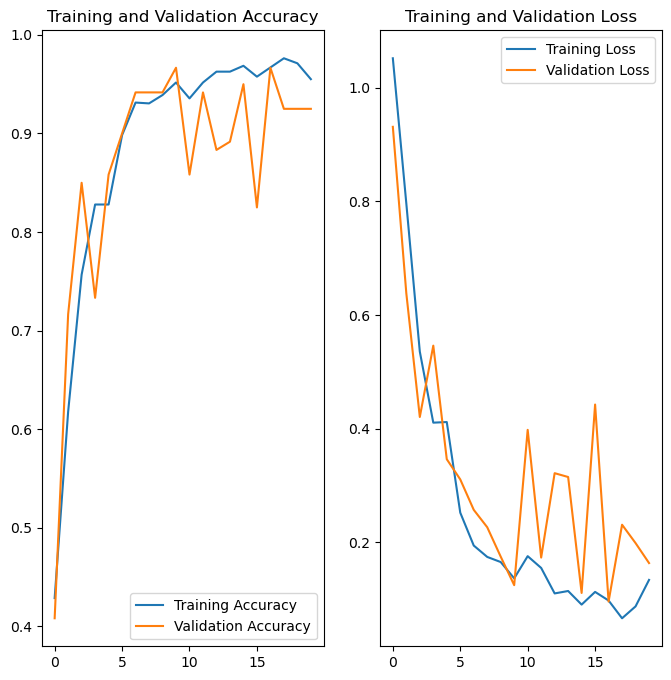

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(5):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

2/2 [==============================] - 0s 69ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


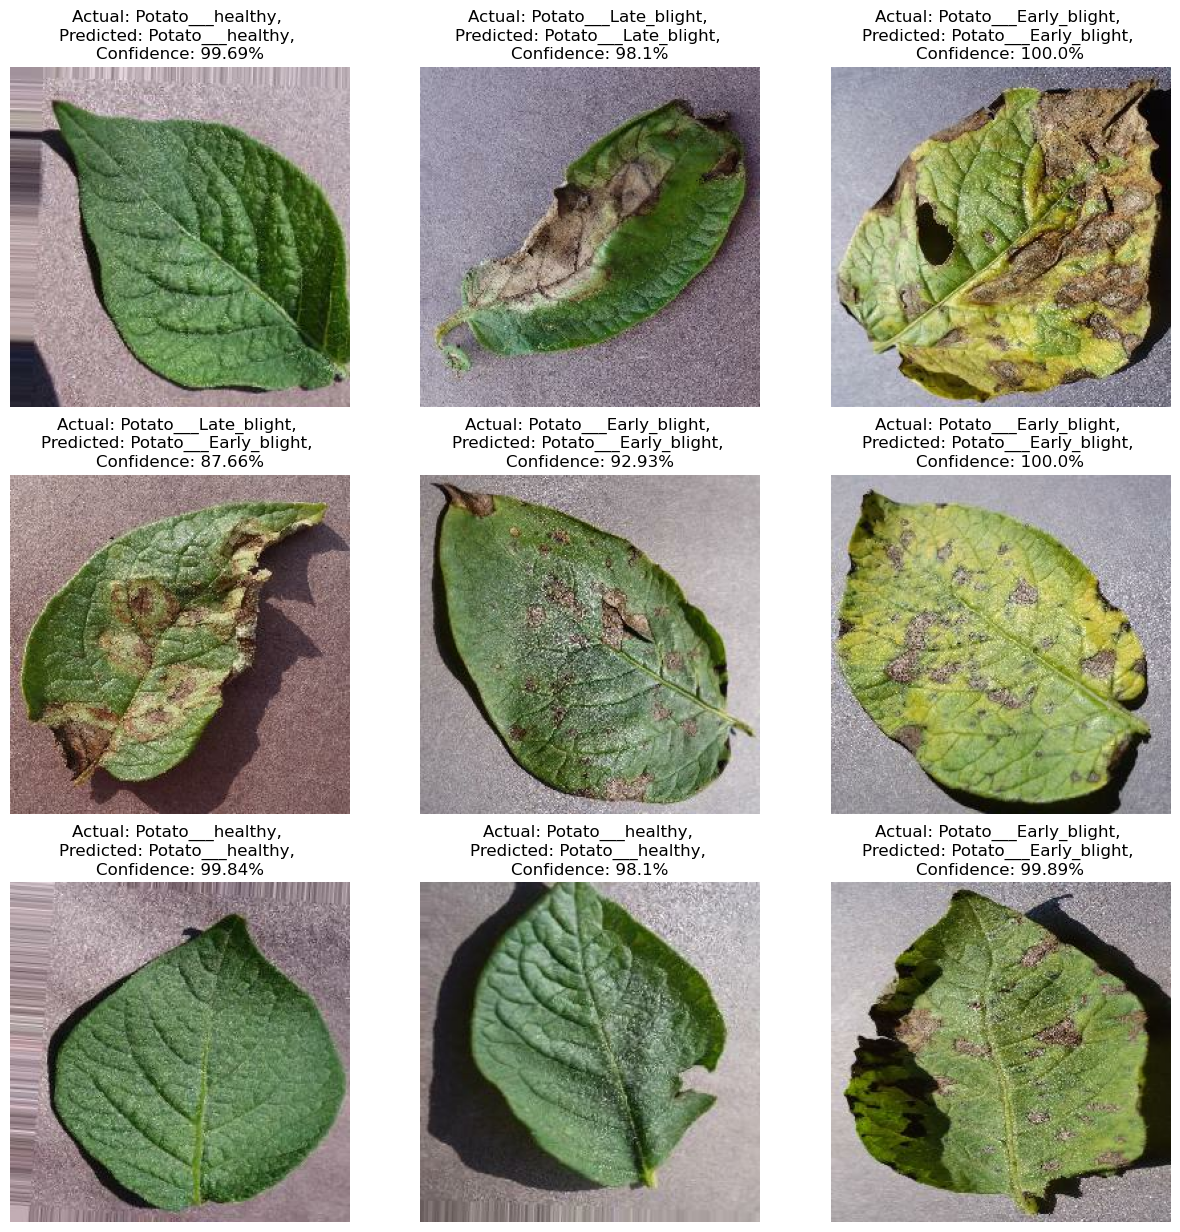

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        65
           1       1.00      0.92      0.96        60
           2       0.99      1.00      0.99        75

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



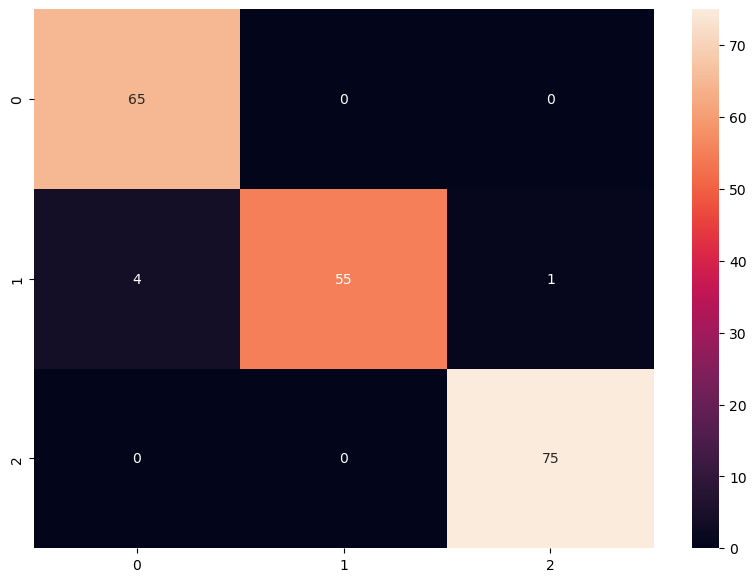

In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [26]:
filename = "Model1-2-BatchSize40.joblib"
joblib.dump(model, filename)

['Model1-2-BatchSize40.joblib']